# Generating the Mercator grid for 1/4 degree ocean

# Mercator projection


For a given $(longitude,latitude) = (\lambda, \phi)$ the isotropic Mercator projection can be written as:  
\begin{equation*}
y = M(\phi) = R \ln \left[ 1+\sin\phi \over \cos\phi \right].  
\end{equation*}
The corresponding inverse function can be written as:
\begin{equation*}
\phi = M^{-1}(y) = \tan^{-1}\left(\sinh(y/R)\right).
\end{equation*}

Here $R$ is called the representative fraction (RF) or the principal scale principal scale of the projection (in units of the radius of the (isotropic) Earth $a_E$). E.g., to project the earth surface to a rectangular map of width $L$ one can use a principal scale of $L/(2\pi a_{E})$ (which corresponds to a "globe" of radius $L/2\pi$.)

These are one of a few equivalent analytic forms of the projection function. For an overview and and more information refer to [https://en.wikipedia.org/wiki/Mercator_projection](the wikipedia).



# Defining a Mercator grid

We want to generate an isotropic Mercator grid corresponding to a 1/4 degree resolution at the equator. Here are the defining parameters of our super-grid:
-- 
1. The equator centered grid cell resolution in longitude direction $\Delta \lambda = {1/8}^\circ $.  
2. The equator centered grid cell resolution in latitude  direction $\Delta \phi = \Delta \lambda$. 
3. The grid in the y direction shall start at a given latitude e.g., $\phi_0 = {-65}^\circ$ and span a given amount northwards, e.g., $\delta \phi = {125}^\circ$.

So:
--   
1. To apply 1. above we partition the equator to $N_x$ intervals. The condition 1. above fixes $N_x=2880$ , since  $\Delta \lambda = (1/8)(\pi/180) = {2\pi\over N_x}$.
2. To achieve 2. above we need to calculate $\Delta y$ given $\Delta \phi$:
\begin{equation*}
\Delta \phi = \Delta y ({d\phi \over dy})|_{y=0} = \Delta y {1\over R} {\cosh(y/R)\over 1+\sinh^2(y/R)} |_{y=0} = {\Delta y \over R}
\end{equation*}
3. To apply 3. above we partition the interval $\delta \phi$ into $N_y$ intervals so that $\Delta\phi = \delta \phi /N_y$. 


Now 2. and 3. fix the value of the representative fraction $R$ as follows:
\begin{align}
R &=& {\Delta y \over \Delta \phi}|_{y=0} \\
  &=& {\Delta y \over \Delta \lambda}|_{y=0} \\
  &=& {(\delta \phi/N_y) \over (\delta \lambda /N_x)}\\
  &=& {2880/360 \over N_y/125}
\end{align}


Note that in the above formula for $R$ the number of latitudinal partitions $N_y$ is as yet arbitrary!


# Mercator grid via package MIDAS

The code snippet below uses the MIDAS package to generate the Mercator grid. We first want to study the calls in this package to find out how MIDAS has been generating the grids. Not that this "imports" a class that was isolated from original MIDAS and hence I call it "pymidas". This is a small fraction of MIDAS and is pure Python.

Note: I am generating this notebook with anaconda Python 3 on my workstation. 

First let's take a look at the grid generated straight from pymidas for a given longitude (since the grid is homogeneous in x direction).

In [2]:

from pymidas.rectgrid_gen import supergrid
import numpy as np


refine=2  # Set to 2 for GIS_025 grid and 4 for GIS_0125
lat0=-65.0 # This is a nominal starting latitude for Mercator grid
lon0=-300. # Starting longitude
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. 
nx=1440*refine
ny=700*refine

#### Begin Mercator Grid

print ('constructing a mercator supergrid with (ny,nx) = ',ny,nx)
print ('nominal starting lat and starting longitude =',lat0, lon0)
print ('and nominal width in latitude = ',lenlat)

mercator=supergrid(nxtot=nx,xstart=lon0,lenx=lenlon,
                   nytot=ny,ystart=lat0,leny=lenlat,
                   config='mercator',axis_units='degrees',cyclic_x=True)

mercator.grid_metrics()
mercator.write_nc('mercator_supergrid.nc')

print ("mercator max/min latitude=", mercator.y.max(),mercator.y.min())
print ("mercator nj,ni=", mercator.y.shape[0]-1,mercator.y.shape[1]-1)
print ("mercator starting longitude=",mercator.x[0,0])
print ("mercator ending longitude=",mercator.x[0,-1])

print("mercator start/end longitudes=",mercator.y[0,0],mercator.y[-1,0])

constructing a mercator supergrid with (ny,nx) =  1400 2880
nominal starting lat and starting longitude = -65.0 -300.0
and nominal width in latitude =  125.0
mercator max/min latitude= 64.0589597296948 -66.85954724706843
mercator nj,ni= 1400 2880
mercator starting longitude= -300.0
mercator ending longitude= 60.0
mercator start/end longitudes= -66.85954724706843 64.0589597296948


In [3]:
import matplotlib.pyplot as plt

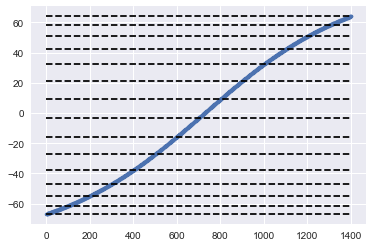

In [4]:
plt.plot( mercator.y[:,0], '.');
for j in np.arange(0,ny+1,100):
    plt.plot([0,1400],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

Or in terms of latitude degrees rather than the y-index.

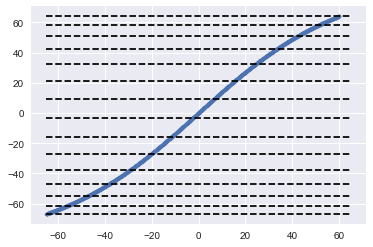

In [5]:
import seaborn as sns; sns.set()
PI_180 = np.pi/180.
y0=lat0
geo_lat=np.zeros(ny+1)
for j in np.arange(ny+1):
    geo_lat[j] = y0 + j * lenlat/ny
plt.plot(geo_lat, mercator.y[:,0], '.');

for j in np.arange(0,ny+1,100):
    plt.plot([-65,65],[mercator.y[j,0],mercator.y[j,0]],linestyle='dashed',color='black')

Notice that at first glance this y-grid is unlike what one expects from a "Mercator projection". A Mercator projection (equation 1) is supposed to get stretched (and diverge) as we move towards the poles giving rise to the famous illusion of the Greenland and Antarctica being as bigger than Africa (which in fact they are only a fraction of). This is not the fault of the software, we are looking at the wrong mapping! A Mercator map is not the same as a Mercator grid, in fact they have an inverse map relation. This is a presentation of equation  2. 

# Producing Mercator grid from equations (ab initio)

First let's make sure we can reproduce the MIDAS package function Int_dj_dy with the Mercator projection equation 1.

Mercator projection scale  458.3662361046586


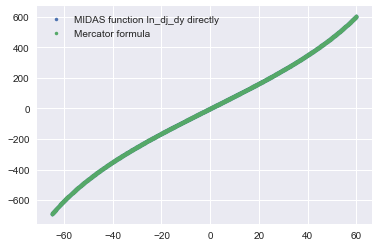

In [149]:
PI_180 = np.pi/180.
y0=lat0*PI_180
int_dj_dy_=np.zeros(ny+1)
geo_lat=np.zeros(ny+1)
merc_lat=np.zeros(ny+1)
Intdjdy=np.zeros(ny+1)

IC0 = nx/lenlon/PI_180 #This is nx/2pi for global grid

R = IC0 #Mercator projection scale
print("Mercator projection scale ",R)
for j in np.arange(ny+1):
    y = y0 + j* PI_180 * lenlat/ny
    #This is the formula for the function Int_dj_dy used in MIDAS/rectgrid_gen.py
    #There is no need for splitting the function in two pieces depending on sgn(y) as is done in MIDAS!
#    if(y >= 0.0):
#        int_dj_dy_[j]= R*(np.log((1.0+np.sin(y))/np.cos(y)))
#    else:
#        int_dj_dy_[j]=-R*(np.log((1.0-np.sin(y))/np.cos(y)))

    #This is calling the MIDAS function Int_dj_dy directly
    Intdjdy[j]=mercator.Int_dj_dy(y) 
    
    #The following is the formula for Mercator projection equation(1)
    #where R is the scale factor of the projection 
    merc_lat[j]=R*(np.log((1.0+np.sin(y))/np.cos(y))) 
    geo_lat[j] = y / PI_180

plt.plot(geo_lat,Intdjdy,    '.',label="MIDAS function In_dj_dy directly")        
#plt.plot(geo_lat,int_dj_dy_, '.',label="MIDAS function In_dj_dy copied")        
plt.plot(geo_lat,merc_lat,   '.',label="Mercator formula")        
plt.legend(loc=0)



The graphs are on top of each other. So, it seems MIDAS is setting the scale of the projection equal to 
$N_x/\delta\lambda$ rather than what we found above ${N_x/\delta\lambda \over N_y/\delta\phi}$. 
This has no effect on the inverse function calculation via the root finder and MIDAS still finds the correct inverse projection. Why?

MIDAS -61.65247844908551 53.8972352072978
formu -61.652478449085486 53.89723520729779
MIDAS 0.0 0.06377553601608375
formu 0.0 0.06377553601608375
1.0000000000000004
1.0000000000000002


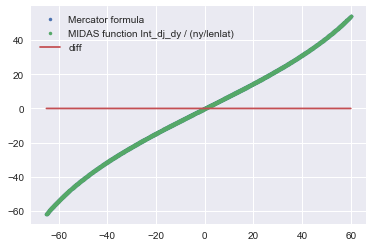

In [160]:
###specified parameters of the Mercator grid
lat0=-65.0  #starting latitude (on the Mercator grid)
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. # nominal longitude range of Mercator grid
refine = 2
nx=1440*refine  # number of grid points in x direction
ny=700*refine   # number of grid points in y direction
PI_180 = np.pi/180.
y0=lat0*PI_180

#IC0 = nx/lenlon/PI_180= (ny/lenlat)*R(in degrees)
R=((nx/lenlon)/(ny/lenlat))
grid_y=np.zeros(ny+1)
for j in np.arange(ny+1):
    y = y0 + j* PI_180 * lenlat/ny
    grid_y[j] = R*(np.log((1.0+np.sin(y))/np.cos(y))) / PI_180
    Intdjdy[j]=mercator.Int_dj_dy(y) / (ny/lenlat)
    
plt.plot(geo_lat, grid_y , '.',label="Mercator formula")
plt.plot(geo_lat, Intdjdy, '.',label="MIDAS function Int_dj_dy / (ny/lenlat)")
plt.plot(geo_lat, Intdjdy-grid_y,label="diff")
plt.legend(loc=0)

print("MIDAS",Intdjdy[0],Intdjdy[-1])
print("formu",grid_y[0],grid_y[-1])
print("MIDAS",Intdjdy[728],Intdjdy[729])
print("formu",grid_y[728],grid_y[729])

print(Intdjdy[0]/grid_y[0])
print(Intdjdy[-1]/grid_y[-1])

This is the function M we have to invert to produce a mercator grid. (Why? Is that a totally obvious fact?) And that is what MIDAS tries to do via a root finder (solve y=M(x) for x given y).


There is a problem with the array index for the inverse that MIDAS calculates mercator.y[i,j] . As the direct projection above, the inverse too is supposed to be zero for the index 728 but it seems to be one index off!

In [161]:

print(" j     lat     M      M_inv")
for j in (729,728,727,726):
    print('{:d},{:7.3f},{:7.3f},{:7.3f}'.format(j,geo_lat[j],Intdjdy[j], mercator.y[j,0]))


 j     lat     M      M_inv
729,  0.089,  0.064,  0.250
728,  0.000,  0.000,  0.125
727, -0.089, -0.064,  0.000
726, -0.179, -0.128, -0.125


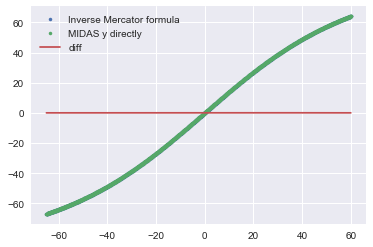

In [132]:
R=(nx/lenlon)/(ny/lenlat)

grid_y=np.zeros(ny+1)
grid_midas_shifted=np.zeros(ny+1)
for j in np.arange(ny+1):
    y = y0 + j* PI_180 * lenlat/ny
    grid_y[j] = np.arctan(np.sinh(y/R)) / PI_180

for j in np.arange(1,ny+1):
    grid_midas_shifted[j] = mercator.y[j-1,0]
    
plt.plot(geo_lat, grid_y,          '.',label="Inverse Mercator formula")
plt.plot(geo_lat, mercator.y[:,0], '.',label="MIDAS y directly")
plt.plot(geo_lat, mercator.y[:,0]-grid_y,label="diff")
#plt.plot(geo_lat, grid_midas_shifted, '.',label="MIDAS y shifted")
plt.legend(loc=0)

#print("latit",geo_lat[0],geo_lat[728],geo_lat[-1])
#print("MIDAS",mercator.y[0,0],mercator.y[728,0],mercator.y[-1,0])
#print("formu",grid_y[0],grid_y[728],grid_y[-1])
#print("shift",grid_midas_shifted[1],grid_midas_shifted[728],grid_midas_shifted[-1])


In [106]:
#Check dy matches between the two formulations

print(mercator.y[728,0]-mercator.y[727,0], grid_y[729]-grid_y[728])
print(mercator.y[727,0]-mercator.y[726,0], grid_y[728]-grid_y[727])
print("")
print(mercator.y[730,0], grid_y[730])
print(mercator.y[729,0], grid_y[729])
print(mercator.y[728,0], grid_y[728])
print(mercator.y[727,0], grid_y[727])
print(mercator.y[726,0], grid_y[726])
print(mercator.y[725,0], grid_y[725])


1400
0.12499990084080814 0.1249999008408066
0.12499990084080384 0.1249999008408066

0.3749973227271327 0.24999920672923703
0.2499992067292401 0.1249999008408066
0.12499990084080814 0.0
0.0 -0.1249999008408066
-0.12499990084080384 -0.24999920672925488
-0.2499992067292506 -0.3749973227271452


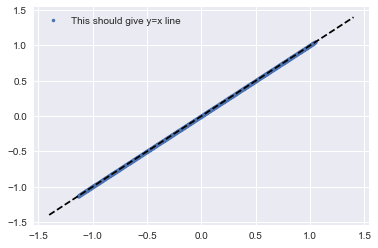

In [107]:
#Check if we invert MIDAS inverse with the Mercator projection formula we get identity

grid_y=np.zeros(ny+1)
y_rad=np.zeros(ny+1)

y0=lat0* PI_180


for j in np.arange(ny+1):
    y_rad[j] = y0 + j* PI_180 * lenlat/ny
    y = mercator.y[j,0] * PI_180
#    y =  np.arctan(np.sinh(y_rad[j]/R))  
    grid_y[j] = R*(np.log((1.0+np.sin(y))/np.cos(y)))
    
    
plt.plot(y_rad, grid_y,          '.',label="This should give y=x line")

plt.plot([-1.4,1.4],[-1.4,1.4], linestyle='dashed',color='black')        

plt.legend(loc=0)


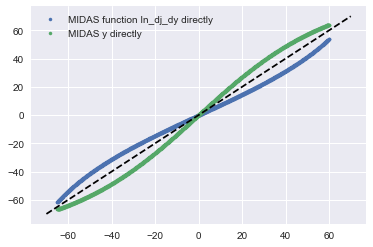

In [162]:
#check the shapes of M and M_inverse look right (symmetric in y=x)
import seaborn as sns; sns.set()
grid_y=np.zeros(ny+1)
y_rad=np.zeros(ny+1)
Intdjdy=np.zeros(ny+1)

y0=lat0

for j in np.arange(ny+1):
    y_rad[j] = y0 + j* lenlat/ny
    grid_y[j] = mercator.y[j,0]
    Intdjdy[j]= mercator.Int_dj_dy(y_rad[j]*PI_180)/(ny/lenlat)
    
plt.plot(y_rad,Intdjdy,'.',label="MIDAS function In_dj_dy directly")     
plt.plot(y_rad, grid_y,'.',label="MIDAS y directly")
plt.plot([-70,70],[-70,70], linestyle='dashed',color='black')        
plt.legend(loc=0)


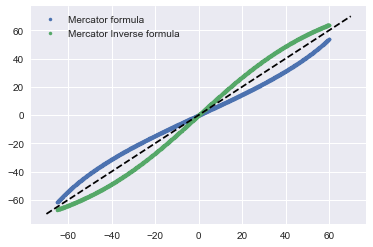

In [125]:
#check the shapes of analytic fomulas for M and M_inverse look right (symmetric in y=x). 
#Of course this is silly.
###specified parameters of the Mercator grid
lat0=-65.0  #starting latitude (on the Mercator grid)
lenlat=125. # nominal latitude range of Mercator grid
lenlon=360. # nominal longitude range of Mercator grid
refine = 2
nx=1440*refine  # number of grid points in x direction
ny=700*refine   # number of grid points in y direction
R=(nx/lenlon)/(ny/lenlat)
###
import seaborn as sns; sns.set()
grid_y=np.zeros(ny+1)
y_rad=np.zeros(ny+1)
y_deg=np.zeros(ny+1)
y_inv=np.zeros(ny+1)

y0=lat0* PI_180


for j in np.arange(ny+1):
    y_rad[j] = y0 + j* PI_180 * lenlat/ny
    y_inv[j] =  np.arctan(np.sinh(y_rad[j]/R))  /PI_180
    grid_y[j] = R*(np.log((1.0+np.sin(y_rad[j]))/np.cos(y_rad[j]))) /PI_180
    y_deg[j] = y_rad[j] / PI_180
    
    
plt.plot(y_deg, grid_y,'.',label="Mercator formula")
plt.plot(y_deg, y_inv ,'.',label="Mercator Inverse formula") 
plt.plot([-70,70],[-70,70], linestyle='dashed',color='black')        
plt.legend(loc=0)


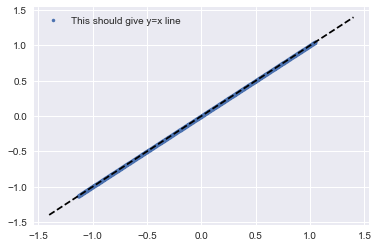

In [18]:
grid_y=np.zeros(ny+1)
y_rad=np.zeros(ny+1)

y0=lat0* PI_180


for j in np.arange(ny+1):
    y_rad[j] = y0 + j* PI_180 * lenlat/ny
    y =  np.arctan(np.sinh(y_rad[j]/R))  
    grid_y[j] = R*(np.log((1.0+np.sin(y))/np.cos(y)))
    
    
plt.plot(y_rad, grid_y,          '.',label="This should give y=x line")

plt.plot([-1.4,1.4],[-1.4,1.4], linestyle='dashed',color='black')        

plt.legend(loc=0)


Let's investigate how MIDAS is calculating its mercator.y. 


In [43]:
jRef=np.floor(-ny*lat0/lenlat) #=728
fnRef=mercator.Int_dj_dy(0.0)
y0=lat0*PI_180
grid_y=np.zeros(ny+1)
for j in np.arange(ny+1):
  jd = fnRef + (j-jRef+1) # -727.0 to +673.0
  #self.grid_y[j]=self.find_root_y(jd,y0,-0.5*numpy.pi,0.5*numpy.pi,itt)
  #grid_y_midas[j] = mercator.y[:,0]  

0.0 66.51326044311186


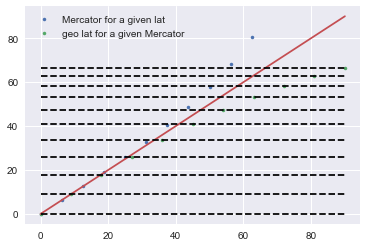

In [19]:
PI_180 = np.pi/180.
y0=0 #lat0*PI_180
ny=10
grid_y=np.zeros(ny+1)
geo_lat=np.zeros(ny+1)
merc_lat=np.zeros(ny+1)
R=1

#Here's the Mercator latitude grid, merc_lat 
#generated for a uniform geographical latitude grid, geo_lat 
lenlat=125./2 # nominal latitude range of Mercator grid
for j in np.arange(ny+1):
    y = y0 + j* PI_180 * lenlat/ny
    merc_lat[j]=R*(np.log((1.0+np.sin(y))/np.cos(y))) / PI_180
    geo_lat[j] = y / PI_180

plt.plot(geo_lat,merc_lat, '.',label="Mercator for a given lat")        

    
#But this is not what we want! 
#We want a uniformly (distributed) Mercator grid on geo_lat interval [-65,65] 
    
lenlat=180./2 # nominal latitude range of Mercator grid
for j in np.arange(ny+1):
    y = y0 + j* PI_180 * lenlat/ny
#    merc_lat[j]=(np.log((1.0+np.sin(y))/np.cos(y))) / PI_180
    grid_y[j] = np.arctan(np.sinh(y/R)) / PI_180
    geo_lat[j] = y / PI_180


print(grid_y[0],grid_y[-1])    
    
    
plt.plot(geo_lat,grid_y, '.',label="geo lat for a given Mercator")        

plt.plot([0.0,90.],[0.,90.])        
plt.legend(loc=0)


for j in np.arange(ny+1):
    plt.plot([0.0,90.0],[grid_y[j],grid_y[j]],linestyle='dashed',color='black')